In [ ]:
!pip install opencv-python-headless Pillow

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from google.colab import files



In [244]:
# Cargar imagen desde archivo
uploaded = files.upload()
filename = next(iter(uploaded))
imagen_bgr = cv2.imread(filename)
imagen_rgb = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2RGB)



Saving test-01 (7).webp to test-01 (7) (2).webp


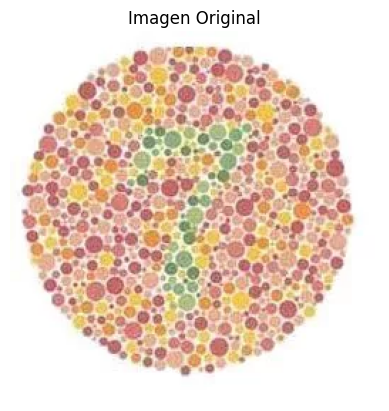

In [245]:
# Mostrar imagen original
plt.imshow(imagen_rgb)
plt.title('Imagen Original')
plt.axis('off')
plt.show()



In [246]:
# Definir función para crear patrones optimizados con tamaño más fino
def crear_patron(tipo, tamaño=6):  # Tamaño reducido a 8
    img = Image.new('L', (tamaño, tamaño), 255)
    draw = ImageDraw.Draw(img)
    if tipo == 'rayas_horizontales':
        for i in range(0, tamaño, 2):
            draw.line((0, i, tamaño, i), fill=0, width=1)
    elif tipo == 'puntos_grandes':
        for x in range(1, tamaño, 6):  # Espaciado reducido
            for y in range(1, tamaño, 6):
                draw.ellipse((x, y, x+3, y+3), fill=0)  # Puntos más grandes (3x3)
    elif tipo == 'diagonales_dobles':
        for i in range(-tamaño, tamaño, 2):
            draw.line((i, tamaño, i+tamaño, 0), fill=0, width=1)
            draw.line((i, 0, i+tamaño, tamaño), fill=0, width=1)
    elif tipo == 'cuadricula':
        for x in range(0, tamaño, 2):
            for y in range(0, tamaño, 2):
                draw.rectangle((x, y, x+2, y+2), outline=0, width=1)
    return np.array(img)


In [247]:
# Convertir a HSV
imagen_hsv = cv2.cvtColor(imagen_rgb, cv2.COLOR_RGB2HSV)

# Rangos de color optimizados para daltonismo
rangos_colores = {
    'rojo':  [(0, 70, 50), (10, 255, 255)],
    'verde': [(36, 25, 25), (86, 255,255)],
    'azul':  [(94, 80, 2), (126, 255, 255)],
    'amarillo': [(15, 100, 100), (35, 255, 255)]
}




In [248]:
# Patrones optimizados para alta diferenciación
patrones = {
    'verde': crear_patron('rayas_horizontales'),
    'azul': crear_patron('puntos_grandes'),
    'rojo': crear_patron('diagonales_dobles'),
    'amarillo': crear_patron('cuadricula')
}



In [249]:
# Precomputar patrones para toda la imagen
imagen_resultado = np.ones(imagen_rgb.shape[:2], dtype=np.uint8) * 255
for color, (bajo, alto) in rangos_colores.items():
    # Crear máscara optimizada
    mascara = cv2.inRange(imagen_hsv, np.array(bajo), np.array(alto))

    # Dilatar máscara para suavizar bordes
    kernel = np.ones((3, 3), np.uint8)
    mascara = cv2.dilate(mascara, kernel, iterations=1)

    # Aplicar patrón de forma eficiente
    patron = patrones[color]
    tile = np.tile(patron, (imagen_resultado.shape[0] // patron.shape[0] + 1,
                            imagen_resultado.shape[1] // patron.shape[1] + 1))
    tile = tile[:imagen_resultado.shape[0], :imagen_resultado.shape[1]]

    # Usar np.where con máscara para aplicar el patrón
    imagen_resultado = np.where(mascara == 255, tile, imagen_resultado)



In [250]:
# Postprocesamiento: Aumentar contraste
imagen_resultado = cv2.convertScaleAbs(imagen_resultado, alpha=1.2, beta=0)



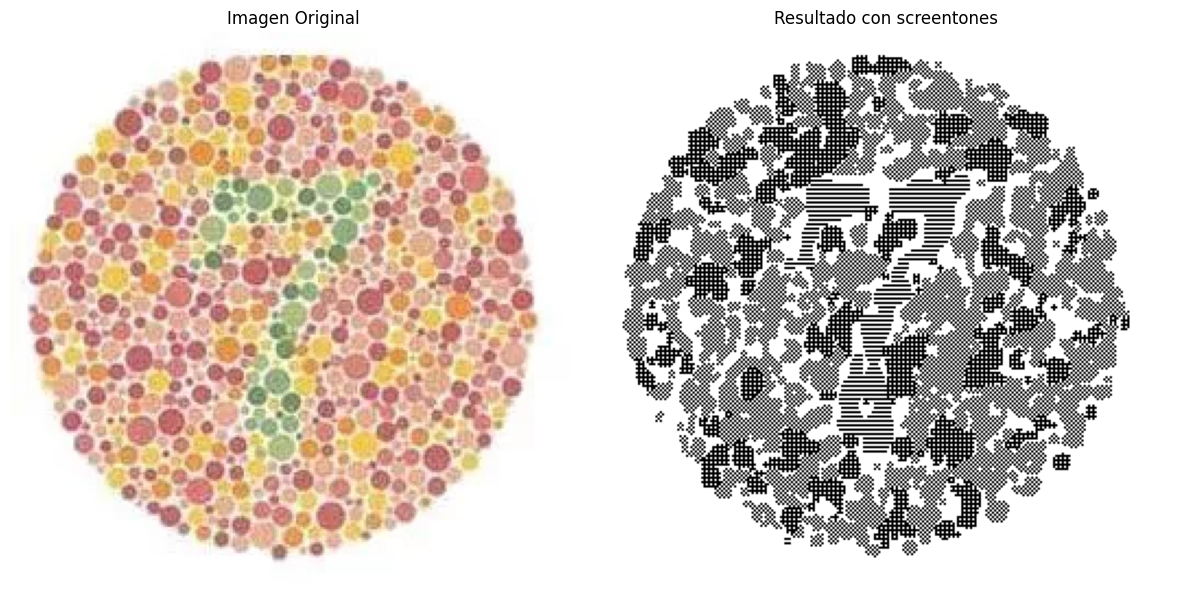

In [251]:
# Mostrar imagen original y resultado con screentones lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(imagen_rgb)
ax1.set_title('Imagen Original')
ax1.axis('off')
ax2.imshow(imagen_resultado, cmap='gray')
ax2.set_title('Resultado con screentones')
ax2.axis('off')
plt.tight_layout()
plt.show()

